In [2]:
from ase.io import read
import matplotlib.pyplot as plt
import numpy as np
from ase.geometry import analysis
plt.style.use('~/plot.mplstyle')
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import seaborn as sns
from itertools import chain
from matscipy.angle_distribution import angle_distribution
from ase.neighborlist import neighbor_list
from matscipy import rings


In [3]:
def make_neigh(atoms, cutoff):
    i,j=(neighbor_list('ij', atoms, cutoff))
    neigh=np.stack((i.T,j.T), axis=1)

    # Initialize a list of empty lists for each atom
    bonded_atoms = [[] for _ in range(len(atoms))]

    # Populate the list with neighboring atoms
    for bond in neigh:
        a, b = bond
        bonded_atoms[a].append(b)
        bonded_atoms[b].append(a)
    
    bonded_atoms=[np.unique(bonds) for bonds in bonded_atoms]

    return bonded_atoms


def comp_angles(atoms, cutoff):
    bonded_atoms=make_neigh(atoms, cutoff)

    angles=[]
    paths=[]

    for id2 in range(0, len(atoms)): # cycle through all atomic indices

        for id3 in bonded_atoms[id2]: #cycle through all id2's bonded neighbors
            n2_ids = [item for item in bonded_atoms[id2] if item != id3]

            for id1 in n2_ids: #cycle through id2's other bonded neighbors            
                dih=atoms.get_angle(id1,id2,id3, mic=True)
                path = [id1,id2,id3]
                
                if path[::-1] in paths:
                    pass
                else:
                    paths.append(path)
                    angles.append(dih)

    return angles

def si_coord(atoms, cutoffs = {('Si', 'Si'): 3.1,('Si', 'H'): 2, ('H', 'H'):1.2}):
    i, j, D = neighbor_list('ijD', atoms, cutoffs)

    count = np.zeros(len(atoms), dtype=int)

    # Count neighbors
    for idx in i:
        count[idx] += 1

    # Extract only Si atoms
    si_indices = [atom.index for atom in atoms if atom.symbol == 'Si']
    count_Si = count[si_indices]
    return count_Si

def rings_distribution(atoms, cutoff, maxlength=20):
    atoms=atoms[atoms.numbers==14]
    rings_tmp = rings.ring_statistics(atoms, cutoff, maxlength=maxlength)
    
    # Pad the array to ensure it matches the desired maximum length
    dist_tmp = np.pad(rings_tmp, (0, maxlength + 5 - len(rings_tmp)))
    
    # Extract ring counts up to `maxlength`
    rings_dist = dist_tmp[:maxlength+1]
    rings_dist_frac = rings_dist / np.sum(rings_dist)  # Convert to percentage


    # Return results in a dictionary
    rings_length = np.arange(0, maxlength + 1)
    result = {
        'rings_length': rings_length.tolist(),
        'rings_dist': rings_dist.tolist(),
        'rings_dist_frac': rings_dist_frac.tolist()
    }

    return result   

/var/folders/z4/v8cnfld964b8x3vqdvtc45pr0000gr/T/ipykernel_58419/3704249936.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


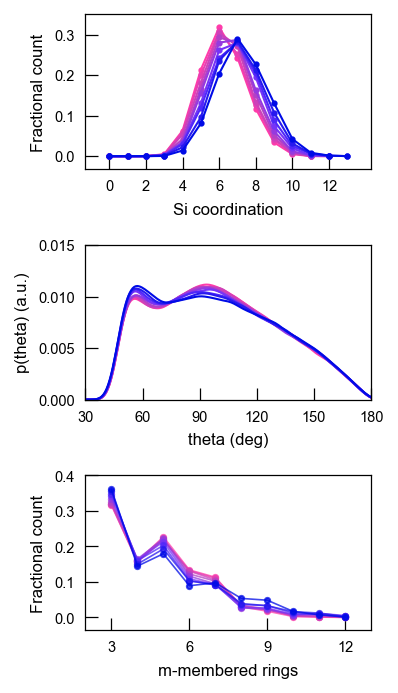

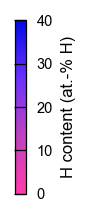

In [4]:

centim = 1/2.54
fig, axes = plt.subplots(3, 1, figsize=(7*centim, 12*centim), sharex=False)

Hconcs = np.arange(0, 45, 5)
repeats = np.arange(1, 11)

# Define custom color scale
colors_rgb = [
    mcolors.to_rgb('#FF3CAA'),  
    mcolors.to_rgb('#BE43BE'),
    mcolors.to_rgb('#6C32FF'), 
    mcolors.to_rgb('#000BE6')   
]
custom_cmap = LinearSegmentedColormap.from_list('custom_hsla_gradient', colors_rgb)
norm = mcolors.Normalize(vmin=min(Hconcs), vmax=max(Hconcs))  # Normalize Hconc range


max_ring_length = 16
ring_lengths = np.arange(0, max_ring_length+1)


for i, Hconc in enumerate(Hconcs):
    color = custom_cmap(norm(Hconc))

    all_Si_counts = []   # collect CN across repeats
    SiSi_angles = []
    SiH_angles = []

    rings_fractional = np.zeros((len(repeats), max_ring_length+1))

    for repeat in repeats:
        wdir = f'../../data/paper/liquid/Hconc-{Hconc:.0f}/{repeat}'
        atoms = read(f'{wdir}/out_anneal.data', format='lammps-data', atom_style='atomic')

        #Coordination numbers
        try:
            count_Si = np.loadtxt(f'{wdir}/count_Si.txt')
        except:
            count_Si = si_coord(atoms)
            np.savetxt(f'{wdir}/count_Si.txt', count_Si)

        all_Si_counts.extend(count_Si)  # store all repeats

        # Angles
        try:
            SiSi_ang = np.loadtxt(f'{wdir}/SiSi_angles.txt')
        except:
            SiSi_ang = comp_angles(atoms, cutoff={('Si', 'Si'): 3.1})
            np.savetxt(f'{wdir}/SiSi_angles.txt', SiSi_ang)

        SiSi_angles.append(SiSi_ang)

        #Rings
        try:
            rings_dict=np.load(f'{wdir}/rings.npy',allow_pickle='TRUE').item()

        except:
            rings_dict=rings_distribution(atoms, cutoff=3.1, maxlength=max_ring_length)
            np.save(f'{wdir}/rings.npy', rings_dict)

        rings_fractional[repeat-1, :] = rings_dict['rings_dist_frac']

            
    # Flatten lists
    SiSi_angles = list(chain(*SiSi_angles))

    counts = np.bincount(all_Si_counts)
    normed_counts = counts / np.sum(counts)  # probability distribution
    axes[0].plot(np.arange(len(counts)), normed_counts, marker='o', markersize=2, color=color, label=f"H={Hconc}")

    sns.kdeplot(SiSi_angles, color=color, ax=axes[1], common_norm=True)

    # Plot average rings
    rings_fractional_av = np.mean(rings_fractional, axis=0)
    axes[2].plot(ring_lengths[3:13], rings_fractional_av[3:13], marker='.', color=color, alpha=0.75, linewidth=0.8)


axes[0].set_xlabel("Si coordination")
axes[0].set_ylabel("Fractional count")
axes[0].set_xticks(np.arange(0,14,2))

axes[1].set_xlabel("theta (deg)")
axes[1].set_ylabel("p(theta) (a.u.)")
axes[1].set_xlim(left=30, right=180)
axes[1].set_xticks(np.arange(30,210,30))
axes[1].set_yticks(np.arange(0, 0.02, 0.005))

axes[2].set_xlabel("m-membered rings")
axes[2].set_ylabel("Fractional count")
axes[2].set_xlim(left=2, right=13)
axes[2].set_xticks(np.arange(3,15,3))
axes[2].set_yticks(np.arange(0, 0.5, 0.1))

fig.tight_layout()
fig.savefig('liquid-structural_v2.svg', dpi=300)

# Colorbar
fig, ax = plt.subplots(figsize=(0.25, 1.5))
fig.subplots_adjust(left=0.3, right=0.6) 

sm = cm.ScalarMappable(norm=norm, cmap=custom_cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax)
cbar.set_label('H content (at.-% H)')
fig.tight_layout()

